In [19]:
# Useful starting lines
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as sk
from glove_routines import *
from text_classifier import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
 def update_cost(cost, fn, x, w, z, newW, newZ):
    cost = cost - 1/2 * fn* pow(x - np.dot(w,z),2)
    cost = cost + 1/2 * fn* pow(x - np.dot(newW, newZ),2)
    return cost

def glove_SGD(embedding_dim = 20, eta = 0.001, alpha = 3 / 4, epochs = 10, nmax = 100, flags=""):
    print("loading cooccurrence matrix")
    with open('data/cooc.pkl', 'rb') as f:
        cooc = pickle.load(f)
    print("{} nonzero entries".format(cooc.nnz))

    print("using nmax =", nmax, ", cooc.max() =", cooc.max())
    print("initializing parameters : nmax =",nmax,",cooc.max() =", cooc.max(),", embedding_dim =",embedding_dim,", eta =",eta,", alpha =",alpha,", epochs =",epochs,".")
    print("initializing embeddings")
    xs = np.random.normal(size=(cooc.shape[0], embedding_dim))
    ys = np.random.normal(size=(cooc.shape[1], embedding_dim))
    losses = []
    cost = 0
    print("initializing cost")
    for ix, jy, n in zip(cooc.row, cooc.col, cooc.data):
        x = np.log(n)
        fn = min(1.0, (n / nmax) ** alpha)
        w, z = xs[ix, :], ys[jy, :]
        WZ = np.dot(w,z)
        cost = cost + fn * pow(x - WZ,2)
    cost = cost/2
    losses.append(cost)
    print(cost)
    print("Running now")
    for epoch in range(epochs):
        print("epoch {}".format(epoch))
        for ix, jy, n in zip(cooc.row, cooc.col, cooc.data):
            logn = np.log(n)
            fn = min(1.0, (n / nmax) ** alpha)
            x, y = xs[ix, :], ys[jy, :]
            scale = 2 * eta * fn * (logn - np.dot(x, y))
            newX = np.copy(scale * y + xs[ix, :])
            newY = np.copy(scale * x + ys[jy, :])
            cost = update_cost(cost,fn,logn,x,y,newX,newY)
            xs[ix, :] = newX
            ys[jy, :] = newY
            losses.append(cost)
    np.save(str('data/embeddings'+flags), xs)
    return losses

In [ ]:
losses = glove_SGD(flags="test",epochs=1)

loading cooccurrence matrix
6496907 nonzero entries
using nmax = 100 , cooc.max() = 207302
initializing parameters : nmax = 100 ,cooc.max() = 207302 , embedding_dim = 20 , eta = 0.001 , alpha = 0.75 , epochs = 1 .
initializing embeddings
initializing cost
7249766.28328
Running now
epoch 0


(6496908,)


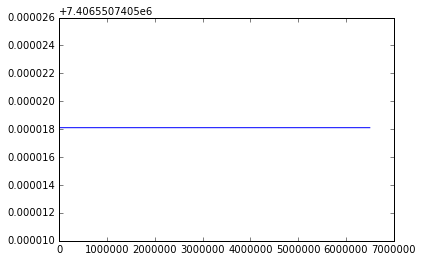

In [31]:
plt.plot(losses)
print(np.shape(losses))